In [67]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import ElasticNet, BayesianRidge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from torch import nn
from torchvision import models, transforms
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel
from transformers import CLIPProcessor, CLIPModel
from xgboost import XGBRegressor

# **Data Analysis**

In [69]:
quantiles = df['likes'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(quantiles)
top_10_likes = df['no_of_comments'].nlargest(10)
print('\nTop 10')
print(top_10_likes)
bottotm_10_likes = df['likes'].nsmallest(10)
print('\nBottom 10')
print(bottotm_10_likes)

0.10     23296.8
0.25     52087.0
0.50    123664.0
0.75    243144.0
0.90    425273.8
0.95    554693.4
0.99    903655.6
Name: likes, dtype: float64

Top 10
81      733973
3143    682323
3144    425096
932     415940
471     279364
3435    215865
71      187754
70      179496
72      167991
884     160827
Name: no_of_comments, dtype: int64

Bottom 10
3281    1431
3256    2179
1158    2230
1401    2402
2651    2493
3037    2522
1150    2602
2652    2664
2663    2769
1403    2781
Name: likes, dtype: int64


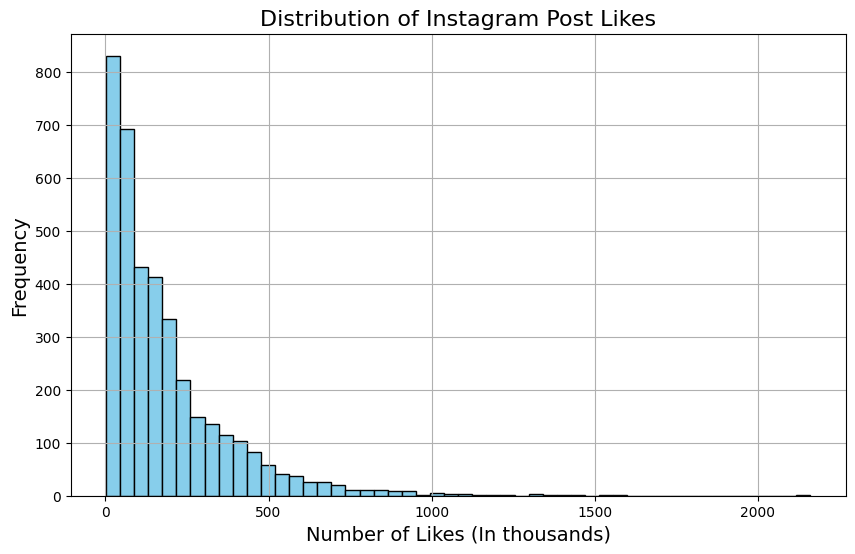

In [70]:
plt.figure(figsize=(10, 6))
plt.hist(df['likes']/(1000), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Instagram Post Likes', fontsize=16)
plt.xlabel('Number of Likes (In thousands)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# **Outlier detection**

In [71]:
df.columns

Index(['likes', 'no_of_comments', 't', 'follower_count_at_t', 'image_path'], dtype='object')

In [72]:
features_for_outliers = ['likes', 'follower_count_at_t', 'no_of_comments']

**Z-score based**

In [73]:
z_scores = np.abs(stats.zscore(df[features_for_outliers]))
outliers_zscore = np.where(z_scores > 3)
len(outliers_zscore[0])

80

**Isolation Forest**

In [74]:
X = df[features_for_outliers]
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df1 = df.copy()
df1['outliers'] = iso_forest.fit_predict(X)
outliers_isolation_forest = np.array(df1[df1['outliers'] == -1].index)

In [75]:
outliers = np.intersect1d(outliers_zscore[0], outliers_isolation_forest)

In [76]:
print(f'The total number of outliers are {len(outliers)}')
print(f'The percentage of outliers in the dataset are {100 * len(outliers) / len(df)}')

The total number of outliers are 77
The percentage of outliers in the dataset are 2.034346103038309


In [77]:
df = df.drop(outliers)

In [78]:
quantiles = df['likes'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(quantiles)
top_10_likes = df['likes'].nlargest(10)
print('\nTop 10')
print(top_10_likes)
bottotm_10_likes = df['likes'].nsmallest(10)
print('\nBottom 10')
print(bottotm_10_likes)

0.10     22872.00
0.25     50956.50
0.50    120197.50
0.75    233563.50
0.90    401359.70
0.95    499844.75
0.99    678823.49
Name: likes, dtype: float64

Top 10
1300    791625
1257    783762
1569    771736
902     763782
1281    755490
1813    747693
699     745995
2697    740494
3147    739962
3319    736407
Name: likes, dtype: int64

Bottom 10
3281    1431
3256    2179
1158    2230
1401    2402
2651    2493
3037    2522
1150    2602
2652    2664
2663    2769
1403    2781
Name: likes, dtype: int64


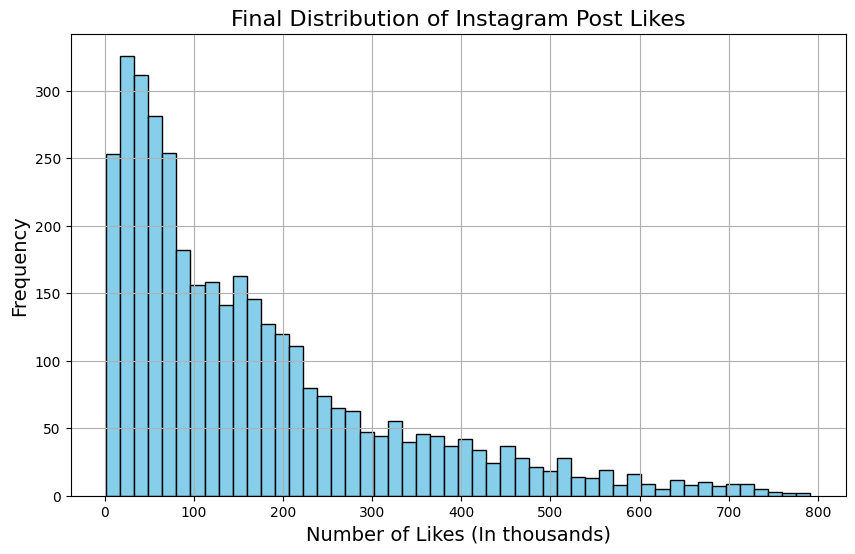

In [79]:
plt.figure(figsize=(10, 6))
plt.hist(df['likes']/(1000), bins=50, color='skyblue', edgecolor='black')
plt.title('Final Distribution of Instagram Post Likes', fontsize=16)
plt.xlabel('Number of Likes (In thousands)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

In [80]:
df.head()

,likes,no_of_comments,t,follower_count_at_t,image_path
0,154552,0,1594174009,40934474,Data/insta_data/0.jpg
1,97386,0,1593571666,40934474,Data/insta_data/2.jpg
2,145632,0,1593136341,40934474,Data/insta_data/4.jpg
3,76461,0,1592981047,40934474,Data/insta_data/6.jpg
4,174620,0,1592703461,40934474,Data/insta_data/8.jpg


# **TRAIN TEST SPLIT**

In [81]:
X = df.drop(['likes'], axis=1)
y = df['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
X_test.head()

,no_of_comments,t,follower_count_at_t,image_path
1842,724,1593170165,10053142,Data/insta_data/4235.jpg
1988,666,1590886757,8838196,Data/insta_data/4471.jpg
2983,142,1594094757,6133188,Data/insta_data/7129.jpg
806,980,1585143407,18362917,Data/insta_data/1936.jpg
817,597,1582206097,18362917,Data/insta_data/1953.jpg


# **Feature Engineering**

**Extracting features from Text**

In [83]:
features = ['no_of_comments', 't', 'follower_count_at_t']

**Correlation matrix**

In [84]:
train_df = pd.DataFrame(X_train, columns=features)
train_df['likes'] = y_train
correlation_matrix = train_df.corr()
print(correlation_matrix['likes'].sort_values(ascending=False))

likes                  1.000000
no_of_comments         0.398350
follower_count_at_t    0.140746
t                     -0.032005
Name: likes, dtype: float64


**Tree Based Regressor**

In [85]:
X = X_train[features]
y = y_train

model = RandomForestRegressor()
model.fit(X, y)

importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importance)

no_of_comments         0.659294
follower_count_at_t    0.189332
t                      0.151374
dtype: float64


# **Mutual Info Regression**

In [86]:
X = X_train.drop('image_path', axis=1)
y = y_train
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_scores)

no_of_comments         0.521248
follower_count_at_t    0.405992
t                      0.090570
dtype: float64


All the features seems relevant for the prediction.

In [87]:
X_train = X_train.drop('image_path', axis=1)
X_test = X_test.drop('image_path', axis=1)

# **Fitting Model on Textual Features**

In [88]:
def test_accuracy(model, X_test, y_test):
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f'MSE: {mse}, R²: {r2}')
  return y_pred

In [89]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = test_accuracy(lr_model, X_test, y_test)

MSE: 20367718331.53084, R²: 0.21758970857139015


In [90]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = test_accuracy(rf_model, X_test, y_test)

MSE: 6048607913.786314, R²: 0.7676473621870216


In [91]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = test_accuracy(xgb_model, X_test, y_test)

MSE: 4877304105.07784, R²: 0.8126420974731445


In [92]:
mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred = test_accuracy(mlp_model, X_test, y_test)

MSE: 25581606115.09994, R²: 0.017302204894400708


In [93]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
}
lgb_model = lgb.train(params, train_data, num_boost_round=100)
y_pred = test_accuracy(lgb_model, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 3
[LightGBM] [Info] Start training from score 166988.384693
MSE: 4701208720.264646, R²: 0.8194066696614356


# **Hyperparameter Tuning**

In [94]:
def tune_hyperparamters(model, X_train, y_train):
  def objective(trial, model):
      param = {
          'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
          'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
          'max_depth': trial.suggest_int('max_depth', 3, 10),
          'subsample': trial.suggest_float('subsample', 0.5, 1.0),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
          'gamma': trial.suggest_float('gamma', 0, 5),
          'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
          'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
          # This line enables GPU training
          'tree_method': 'gpu_hist'
      }

      score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
      return score

  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=100)
  return study.best_params

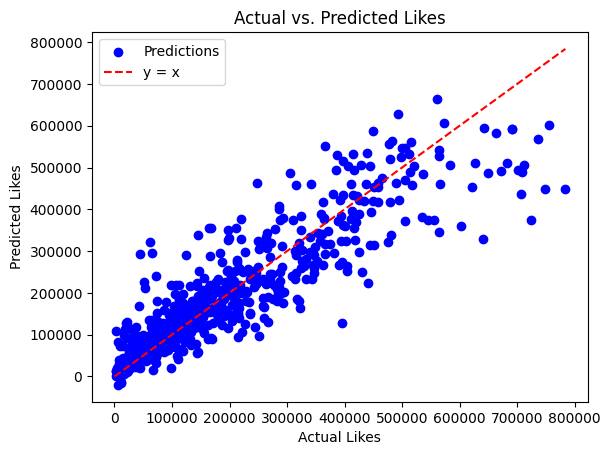

In [95]:
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Actual vs. Predicted Likes')
max_value = max(y_test.max(), y_pred.max())
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='y = x')
plt.legend()
plt.show()

# **Extract Features from Images**

In [96]:
X = df.drop(['likes'], axis=1)
y = df['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, transform=None):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        self.transform = transform  # Added transform parameter

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        likes = self.dataframe.iloc[idx]['likes']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)  # Remove batch dimension

        return pixel_values, torch.tensor(likes, dtype=torch.float32)

In [98]:
def fine_tune_vit(X_train, y_train, num_layers_to_finetune = None, num_epochs=5, batch_size=16, learning_rate=5e-3, patience=3, val_split=0.2):

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=42)
    X_train['likes'] = y_train
    X_val['likes'] = y_val

    class ViTForRegression(nn.Module):
        def __init__(self, vit_model, num_layers_to_finetune):
            super(ViTForRegression, self).__init__()
            self.vit = vit_model
            if num_layers_to_finetune is not None:
              for param in self.vit.parameters():
                param.requires_grad = False
              for param in self.vit.encoder.layer[-num_layers_to_finetune:].parameters():
                param.requires_grad = True

            self.regressor = nn.Linear(self.vit.config.hidden_size, 1)  # Output single value for regression

        def forward(self, pixel_values):
            outputs = self.vit(pixel_values=pixel_values)
            cls_output = outputs.last_hidden_state[:, 0]
            regression_output = self.regressor(cls_output)
            return regression_output


    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
    model = ViTForRegression(vit_model, num_layers_to_finetune)
    val_loss = []

    data_augmentation_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor()
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

    train_dataset = CustomImageDataset(X_train, feature_extractor, transform=data_augmentation_transforms)
    val_dataset = CustomImageDataset(X_val, feature_extractor, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        model.train()
        total_train_loss = 0
        if epoch > 25:
          learning_rate /= 10

        for batch_idx, (images, labels) in enumerate(train_loader):
            if batch_idx % 50 == 0:
                print(f'Started loading batch {batch_idx}')

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            predictions = model(images).squeeze()

            # Compute loss
            loss = criterion(predictions, labels)
            total_train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                predictions = model(images).squeeze()
                loss = criterion(predictions, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model before returning
    model.load_state_dict(best_model_state)

    return model, feature_extractor, val_loss

In [99]:
def fine_tune_clip(X_train, y_train, num_layers_to_finetune=None, num_epochs=5, batch_size=16, learning_rate=5e-3, patience=3, val_split=0.2):

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split, random_state=42)
    X_train['likes'] = y_train
    X_val['likes'] = y_val

    class CLIPForRegression(nn.Module):
        def __init__(self, clip_model, num_layers_to_finetune):
            super(CLIPForRegression, self).__init__()
            self.clip = clip_model
            if num_layers_to_finetune is not None:
                for param in self.clip.parameters():
                    param.requires_grad = False
                for param in self.clip.vision_model.encoder.layers[-num_layers_to_finetune:].parameters():
                    param.requires_grad = True
            self.regressor = nn.Linear(768, 1)

        def forward(self, pixel_values):
            outputs = self.clip.vision_model(pixel_values=pixel_values)
            cls_output = outputs.last_hidden_state[:, 0]
            regression_output = self.regressor(cls_output)
            return regression_output

    # Load CLIP model and processor
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
    model = CLIPForRegression(clip_model, num_layers_to_finetune)

    # Data augmentation and transformations for images
    data_augmentation_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor()
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

    # Custom dataset with image paths
    train_dataset = CustomImageDataset(X_train, processor, transform=data_augmentation_transforms)
    val_dataset = CustomImageDataset(X_val, processor, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    val_loss = []

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        model.train()
        total_train_loss = 0
        if epoch > (9*(num_epochs))/10:
            learning_rate /= 10

        for batch_idx, (images, labels) in enumerate(train_loader):
            if batch_idx % 50 == 0:
                print(f'Started loading batch {batch_idx}')

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            predictions = model(images).squeeze()

            # Compute loss
            loss = criterion(predictions, labels)
            total_train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                predictions = model(images).squeeze()
                loss = criterion(predictions, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()

    # Load the best model before returning
    model.load_state_dict(best_model_state)

    return model, processor, val_loss

In [100]:
clip_model, clip_feature_extractor, clip_val_loss = fine_tune_clip(X_train, y_train, num_layers_to_finetune = None, num_epochs=20)

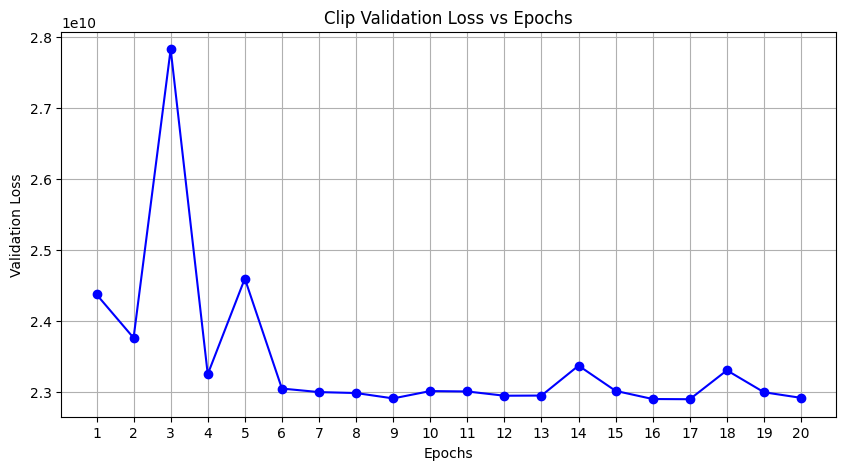

In [42]:
epochs = range(1, len(clip_val_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, clip_val_loss, marker='o', linestyle='-', color='b')
plt.title('Clip Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.xticks(epochs)
plt.grid()
plt.show()

# **Generate and Append Features**

In [101]:
def generate_image_features(model, feature_extractor, X, type = None):
    model.eval()
    image_features = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    with torch.no_grad():
        for idx in range(len(X)):
            img_path = X.iloc[idx]['image_path']
            image = Image.open(img_path).convert("RGB")
            inputs = feature_extractor(images=image, return_tensors="pt")
            pixel_values = inputs['pixel_values'].to(device)

            if type == 'vit':
              outputs = model.vit(pixel_values=pixel_values)
              pooled_output = outputs.pooler_output.squeeze()
              image_features.append(pooled_output.cpu().numpy())

            else:
              outputs = model.clip.vision_model(pixel_values=pixel_values)
              cls_output = outputs.last_hidden_state[:, 0]
              image_features.append(cls_output.cpu().numpy().flatten())

    image_features_df = pd.DataFrame(image_features)  # This should now be 2D
    return image_features_df


In [102]:
def generate_append_features(model, feature_extractor, X, Y, t):
  image_features = generate_image_features(model, feature_extractor, X, t)
  X_reset = X.reset_index(drop=True)
  image_features_reset = image_features.reset_index(drop=True)
  combined_df = pd.concat([X_reset, image_features_reset], axis=1)
  X = combined_df.drop('image_path', axis=1)
  Y = Y.reset_index(drop=True)
  return X, Y

In [58]:
X_train, y_train = generate_append_features(clip_model, clip_feature_extractor, X_train, y_train)
X_test, y_test = generate_append_features(clip_model, clip_feature_extractor, X_test, y_test)

# **Scaling the features**

In [58]:
def scale_features(X):
  numerical_features = ['no_of_comments', 'follower_count_at_t', 't']
  new_numerical_features = ['comments', 'followers', 'time']
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X[numerical_features])
  X_combined = pd.concat([pd.DataFrame(X_scaled, columns=new_numerical_features), X], axis=1)
  X = X_combined.drop(numerical_features, axis=1)
  X.columns = X.columns.astype(str)
  return X

In [60]:
X_train = scale_features(X_train)
X_test = scale_features(X_test)

# **Fitting a model (CLIP)**

In [64]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = test_accuracy(rf_model, X_test, y_test)

MSE: 9269487498.753035, R²: 0.6439197411687637


In [67]:
xgmodel = XGBRegressor()
xgmodel.fit(X_train, y_train)
y_pred = test_accuracy(xgmodel, X_test, y_test)

MSE: 10227691258.253075, R²: 0.6071110963821411


In [71]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
}
lgb_model = lgb.train(params, train_data, num_boost_round=100)
y_pred = test_accuracy(lgb_model, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196444
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 771
[LightGBM] [Info] Start training from score 166988.384693
MSE: 9771550189.030094, R²: 0.6246333876646016


In [86]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)         # Second hidden layer
        self.fc3 = nn.Linear(64, 1)           # Output layer (single value for regression)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
model = RegressionNN(input_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

    avg_test_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')


Epoch [1/100], Loss: 19740388808.9462
Epoch [2/100], Loss: 13798184266.3226
Epoch [3/100], Loss: 13821549028.4731
Epoch [4/100], Loss: 13761175794.2366
Epoch [5/100], Loss: 13818276456.6021
Epoch [6/100], Loss: 13886227951.4839
Epoch [7/100], Loss: 13757782808.7742
Epoch [8/100], Loss: 13647155574.3656
Epoch [9/100], Loss: 13758979776.6882
Epoch [10/100], Loss: 13790090669.4194
Epoch [11/100], Loss: 13817286347.6989
Epoch [12/100], Loss: 13717366905.1183
Epoch [13/100], Loss: 13782640827.1828
Epoch [14/100], Loss: 13723273326.1075
Epoch [15/100], Loss: 13818213827.4409
Epoch [16/100], Loss: 13780825946.8387
Epoch [17/100], Loss: 13754828293.5054
Epoch [18/100], Loss: 13699019445.6774
Epoch [19/100], Loss: 13890990641.5484
Epoch [20/100], Loss: 13704973708.3871
Epoch [21/100], Loss: 13833414567.9140
Epoch [22/100], Loss: 13752778917.1613
Epoch [23/100], Loss: 13757128197.5054
Epoch [24/100], Loss: 13755595621.8495
Epoch [25/100], Loss: 13743801674.3226
Epoch [26/100], Loss: 13738666919.

In [79]:
mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred = test_accuracy(mlp_model, X_test, y_test)

MSE: 26063363648.43984, R²: -0.0012041415663550659


In [80]:
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)
y_pred = test_accuracy(bayesian_model, X_test, y_test)

MSE: 26087474053.918762, R²: -0.002130324316438781


In [81]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
y_pred = test_accuracy(elastic_net_model, X_test, y_test)

MSE: 20810110892.429455, R²: 0.20059553736063196


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.780e+13, tolerance: 7.022e+09
  model = cd_fast.enet_coordinate_descent(


# **Fine Tuned Vision transformer models**

In [104]:
X = df.drop(['likes'], axis=1)
y = df['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
vit_finetuned_model, vit_feature_extractor_finetuned, val_loss = fine_tune_vit(X_train, y_train, num_epochs=16)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch: 1/16
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [1/16], Train Loss: 50755493221.3691
Epoch [1/16], Validation Loss: 52011447188.2105
Epoch: 2/16
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [2/16], Train Loss: 49415633562.6309
Epoch [2/16], Validation Loss: 50028469733.0526
Epoch: 3/16
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [3/16], Train Loss: 47050950594.1477
Epoch [3/16], Validation Loss: 46903616431.1579
Epoch: 4/16
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [4/16], Train Loss: 43707827090.0403
Epoch [4/16], Validation Loss: 43109201408.0000
Epoch: 5/16
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [5/16], Train Loss: 39822981522.8993
Epoch [5/16], Validation Loss: 39107650371.3684
Epoch: 6/16
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [6/16], Train Los

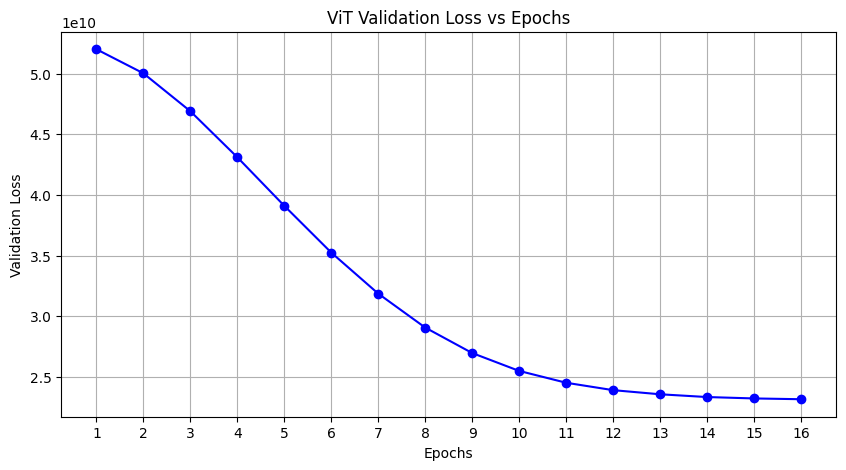

In [99]:
epochs = range(1, len(val_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='b')
plt.title('ViT Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.xticks(epochs)
plt.grid()
plt.show()

In [105]:
X_train, y_train = generate_append_features(vit_finetuned_model, vit_feature_extractor_finetuned, X_train, y_train, 'vit')
X_test, y_test = generate_append_features(vit_finetuned_model, vit_feature_extractor_finetuned, X_test, y_test, 'vit')

In [106]:
X_train = scale_features(X_train)
X_test = scale_features(X_test)

In [107]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = test_accuracy(rf_model, X_test, y_test)

MSE: 8680827194.544699, R²: 0.6665326756502414


In [108]:
xgmodel = XGBRegressor()
xgmodel.fit(X_train, y_train)
y_pred = test_accuracy(xgmodel, X_test, y_test)

MSE: 9699489369.793562, R²: 0.62740159034729


In [110]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
}
lgb_model = lgb.train(params, train_data, num_boost_round=100)
y_pred = test_accuracy(lgb_model, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71307
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 413
[LightGBM] [Info] Start training from score 166988.384693
MSE: 9825796688.684887, R²: 0.6225495499507727


In [114]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)         # Second hidden layer
        self.fc3 = nn.Linear(64, 1)           # Output layer (single value for regression)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
model = RegressionNN(input_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

    avg_test_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')


Epoch [1/100], Loss: 51425404047.1398
Epoch [2/100], Loss: 48274186812.5591
Epoch [3/100], Loss: 37372103107.4409
Epoch [4/100], Loss: 26523652674.0645
Epoch [5/100], Loss: 23796174297.4624
Epoch [6/100], Loss: 23654129520.8602
Epoch [7/100], Loss: 23605178731.3548
Epoch [8/100], Loss: 23628367508.6452
Epoch [9/100], Loss: 23634396974.7957
Epoch [10/100], Loss: 23650272134.8817
Epoch [11/100], Loss: 23590075414.0215
Epoch [12/100], Loss: 23570182331.1828
Epoch [13/100], Loss: 23571141676.0430
Epoch [14/100], Loss: 23629740560.5161
Epoch [15/100], Loss: 23599967077.8495
Epoch [16/100], Loss: 23595302625.7204
Epoch [17/100], Loss: 23587001344.0000
Epoch [18/100], Loss: 23592529787.8710
Epoch [19/100], Loss: 23570115881.2903
Epoch [20/100], Loss: 23543507186.2366
Epoch [21/100], Loss: 23543949994.6667
Epoch [22/100], Loss: 23580716439.3979
Epoch [23/100], Loss: 23557159594.6667
Epoch [24/100], Loss: 23557384522.3226
Epoch [25/100], Loss: 23577715453.2473
Epoch [26/100], Loss: 23546386035.

In [111]:
mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred = test_accuracy(mlp_model, X_test, y_test)

MSE: 23782151057.379074, R²: 0.0864268919706408


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [112]:
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)
y_pred = test_accuracy(bayesian_model, X_test, y_test)

MSE: 20333101368.44649, R²: 0.21891949268045596


In [113]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
y_pred = test_accuracy(elastic_net_model, X_test, y_test)

MSE: 20600754599.569424, R²: 0.20863779891603906


# **ViT model but changing only last few layers**

In [23]:
Vit_model, vit_feature_extractor, vit_val_loss = fine_tune_vit(X_train, y_train, num_layers_to_finetune = 3, num_epochs=30)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/30
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [1/30], Train Loss: 50944020466.2550
Epoch [1/30], Validation Loss: 52543129869.4737
Epoch: 2/30
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [2/30], Train Loss: 50642833823.7852
Epoch [2/30], Validation Loss: 52367968471.5789
Epoch: 3/30
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [3/30], Train Loss: 50756020368.3222
Epoch [3/30], Validation Loss: 52196731418.9474
Epoch: 4/30
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [4/30], Train Loss: 50484752617.6644
Epoch [4/30], Validation Loss: 52025948052.2105
Epoch: 5/30
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [5/30], Train Loss: 50193173696.4295
Epoch [5/30], Validation Loss: 51857894292.2105
Epoch: 6/30
Started loading batch 0
Started loading batch 50
Started loading batch 100
Epoch [6/30], Train Los

# **Using CLIP without fine tuning**

In [138]:
X = df.drop(['likes'], axis=1)
y = df['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
def generate_clip_features(image_paths):
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
    clip_model.eval()
    features = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    clip_model.to(device)

    with torch.no_grad():
        for img_path in image_paths:
            image = Image.open(img_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device)

            outputs = clip_model.get_image_features(**inputs)
            features.append(outputs.cpu().numpy().flatten())

    return pd.DataFrame(features)

In [143]:
def generate_and_append_clip_features(X, Y):
  image_paths = X['image_path']
  clip_features_training = generate_clip_features(image_paths)
  X = pd.concat([X.reset_index(drop=True), clip_features_training.reset_index(drop=True)], axis=1)
  X = X.drop(['image_path'], axis=1)
  Y = Y.reset_index(drop=True)
  return X, Y

In [144]:
X_train, y_train = generate_and_append_clip_features(X_train, y_train)
X_test, y_test = generate_and_append_clip_features(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [145]:
X_train = scale_features(X_train)
X_test = scale_features(X_test)

In [146]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = test_accuracy(rf_model, X_test, y_test)

MSE: 7402883524.049163, R²: 0.7156239024330604


In [147]:
xgmodel = XGBRegressor()
xgmodel.fit(X_train, y_train)
y_pred = test_accuracy(xgmodel, X_test, y_test)

MSE: 7428190938.207592, R²: 0.7146517038345337


In [148]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
}
lgb_model = lgb.train(params, train_data, num_boost_round=100)
y_pred = test_accuracy(lgb_model, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131164
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 515
[LightGBM] [Info] Start training from score 166988.384693
MSE: 6337619648.540099, R²: 0.7565451978731654


In [149]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)         # Second hidden layer
        self.fc3 = nn.Linear(64, 1)           # Output layer (single value for regression)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
model = RegressionNN(input_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

    avg_test_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

Epoch [1/100], Loss: 51590306838.0215
Epoch [2/100], Loss: 50430993011.6129
Epoch [3/100], Loss: 45576714625.3763
Epoch [4/100], Loss: 36284540795.8710
Epoch [5/100], Loss: 27698280822.3656
Epoch [6/100], Loss: 23932893024.3441
Epoch [7/100], Loss: 22872966463.3118
Epoch [8/100], Loss: 22474410650.1505
Epoch [9/100], Loss: 22062891327.3118
Epoch [10/100], Loss: 21684946789.8495
Epoch [11/100], Loss: 21314165176.4301
Epoch [12/100], Loss: 20991201202.9247
Epoch [13/100], Loss: 20628619385.1183
Epoch [14/100], Loss: 20315143663.4839
Epoch [15/100], Loss: 19974309777.8925
Epoch [16/100], Loss: 19661885869.4194
Epoch [17/100], Loss: 19313117437.2473
Epoch [18/100], Loss: 19031187621.1613
Epoch [19/100], Loss: 18696694690.4086
Epoch [20/100], Loss: 18350576684.0430
Epoch [21/100], Loss: 18123059007.3118
Epoch [22/100], Loss: 17752640473.4624
Epoch [23/100], Loss: 17446068416.6882
Epoch [24/100], Loss: 17187065971.6129
Epoch [25/100], Loss: 16903792706.0645
Epoch [26/100], Loss: 16645212391.

In [150]:
mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred = test_accuracy(mlp_model, X_test, y_test)

MSE: 13982370259.74909, R²: 0.4628779615016031


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [152]:
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)
y_pred = test_accuracy(bayesian_model, X_test, y_test)

MSE: 13946607423.97135, R²: 0.4642517634320754


In [151]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
y_pred = test_accuracy(elastic_net_model, X_test, y_test)

MSE: 14007118334.39886, R²: 0.4619272831789827


# **ResNet Model for feature extraction from Images**

In [52]:
X = df.drop(['likes'], axis=1)
y = df['likes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
def extract_features_from_resnet(image_paths):
    resnet = models.resnet50(pretrained=True)
    resnet = nn.Sequential(*list(resnet.children())[:-1])
    resnet.eval()
    features = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    resnet.to(device)

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

    with torch.no_grad():
        for img_path in image_paths:
            image = Image.open(img_path).convert("RGB")
            img_tensor = preprocess(image).unsqueeze(0).to(device)
            output = resnet(img_tensor)
            features.append(output.cpu().numpy().flatten())


    return pd.DataFrame(features)

In [54]:
def generate_and_append_resnet_features(X, Y):
  image_paths = X['image_path']
  clip_features_training = extract_features_from_resnet(image_paths)
  X = pd.concat([X.reset_index(drop=True), clip_features_training.reset_index(drop=True)], axis=1)
  X = X.drop(['image_path'], axis=1)
  Y = Y.reset_index(drop=True)
  return X, Y

In [55]:
X_train, y_train = generate_and_append_resnet_features(X_train, y_train)
X_test, y_test = generate_and_append_resnet_features(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depreca

In [60]:
X_train = scale_features(X_train)
X_test = scale_features(X_test)

In [61]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = test_accuracy(rf_model, X_test, y_test)

MSE: 8789043251.696058, R²: 0.6623756387433644


In [62]:
xgmodel = XGBRegressor()
xgmodel.fit(X_train, y_train)
y_pred = test_accuracy(xgmodel, X_test, y_test)

MSE: 8890090172.066015, R²: 0.6584939956665039


In [63]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
}
lgb_model = lgb.train(params, train_data, num_boost_round=100)
y_pred = test_accuracy(lgb_model, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522844
[LightGBM] [Info] Number of data points in the train set: 2966, number of used features: 2051
[LightGBM] [Info] Start training from score 166988.384693
MSE: 7784767658.987288, R²: 0.7009541160364982


In [64]:
mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred = test_accuracy(mlp_model, X_test, y_test)

MSE: 21475073590.83382, R²: 0.1750515048784913


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [65]:
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)
y_pred = test_accuracy(bayesian_model, X_test, y_test)

MSE: 19331616818.12521, R²: 0.25739075421911806


In [66]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
y_pred = test_accuracy(elastic_net_model, X_test, y_test)

MSE: 19300386245.836334, R²: 0.25859045272084924


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e+13, tolerance: 7.022e+09
  model = cd_fast.enet_coordinate_descent(


# **Using CLIP model directly**

In [180]:
X = df.drop(['likes'], axis=1)
y = df['likes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
data = X_train[0:1000]
texts = data.apply(lambda row: f"Time: {row['t']}, Followers: {row['follower_count_at_t']}, Comments: {row['no_of_comments']}", axis=1).tolist()
images = [Image.open(img_path) for img_path in data['image_path']]

In [ ]:
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    image_features = outputs.image_embeds
    text_features = outputs.text_embeds

In [ ]:
features = torch.cat((image_features, text_features), dim=1)

In [56]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_dim = features.shape[1]
regression_model = RegressionModel(input_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(regression_model.parameters(), lr=0.001)


target_values = torch.tensor(y_train[0:1000].values, dtype=torch.float32).unsqueeze(1)


num_epochs = 100
for epoch in range(num_epochs):
    regression_model.train()
    optimizer.zero_grad()
    outputs = regression_model(features)
    loss = criterion(outputs, target_values)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')